In [308]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.stattools import acf, pacf

In [255]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [256]:
from pmdarima.arima import auto_arima

In [257]:
#import NASDAQ data
df=pd.read_csv("IXIC_v1.csv", sep=",")

In [258]:
#understand data format and clean up data 
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', length=2705, freq=None)

In [259]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [260]:
df.head()


,Close,year,month,day
Date,,,,
2010-01-04,2308.419922,2010,1,4
2010-01-05,2308.709961,2010,1,5
2010-01-06,2301.090088,2010,1,6
2010-01-07,2300.050049,2010,1,7
2010-01-08,2317.169922,2010,1,8


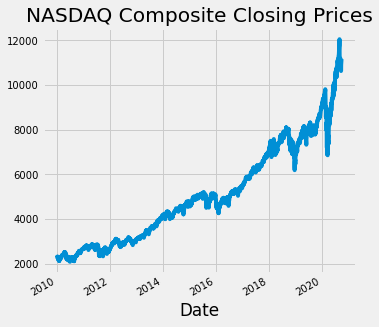

In [261]:
#plot NASDAQ trend 
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(5,5), title= 'NASDAQ Composite Closing Prices', fontsize=10)

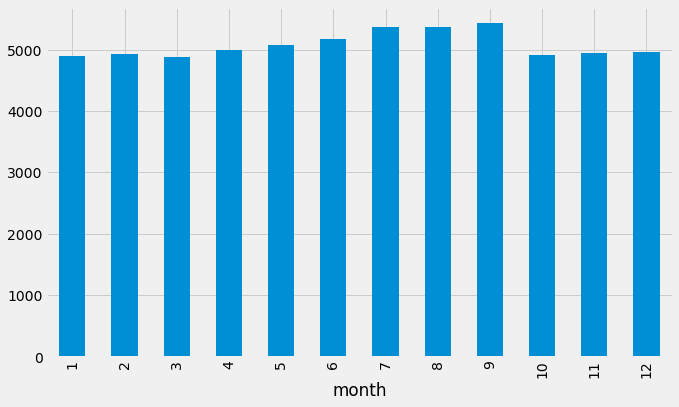

In [262]:
df.groupby('month')['Close'].mean().plot.bar()
#on average, september has the highest average price compares to the other months. 

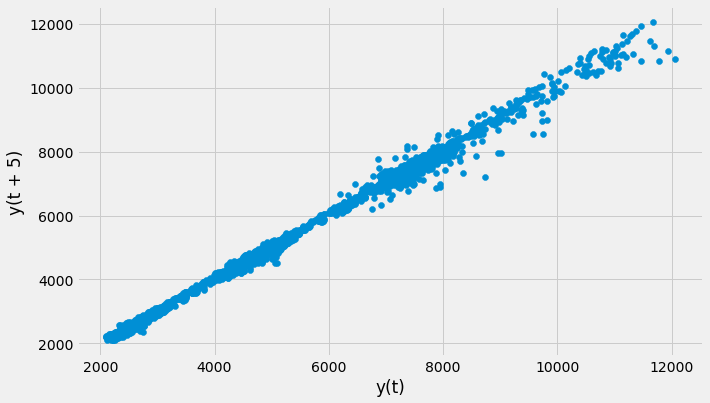

In [263]:
#lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'],lag=5)

#Graph shows a linear pattern. Implies data points are non random and suggests that an autoregressive model might be appropriate.

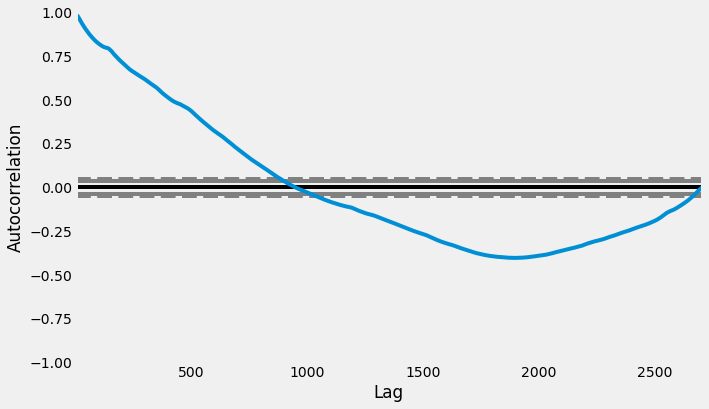

In [264]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
#there is high level of correlation 

In [265]:
#data is not stationary based on high p value
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: 1.4430465972942679
p-value:0.9973011850493003


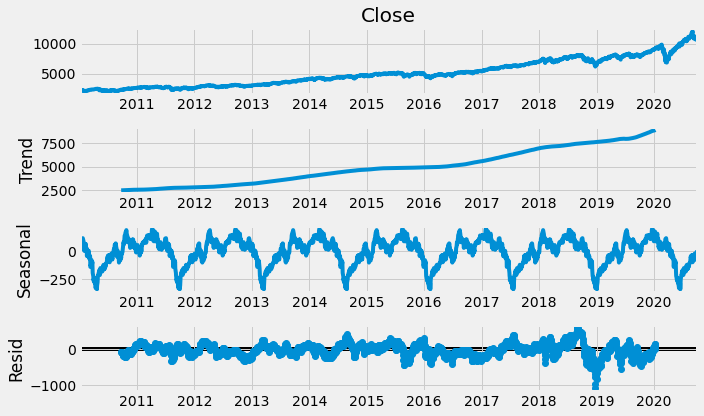

In [266]:
#decompose data
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df['Close'],model= 'addictive',period = 365)
resplot = res.plot()
#data shows upward trend and presents seasonlity

In [267]:
def plot_df(df,x,y,title= "", xlabel = "Date", ylabel='Value',dpi=50):
    plt.plot(x,y)
    plt.show()

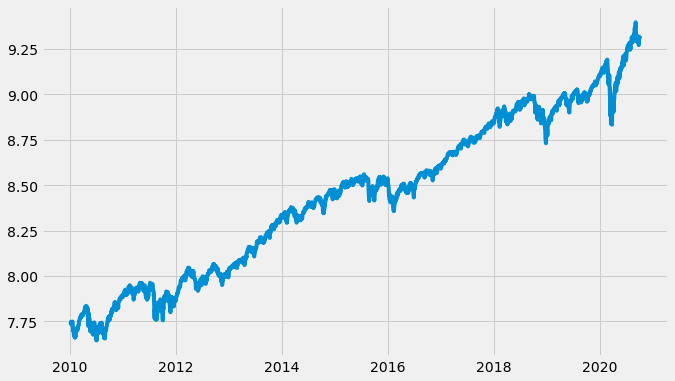

In [268]:
#apply log transformation to stablize data
plt.plot(df.apply(np.log)['Close'])

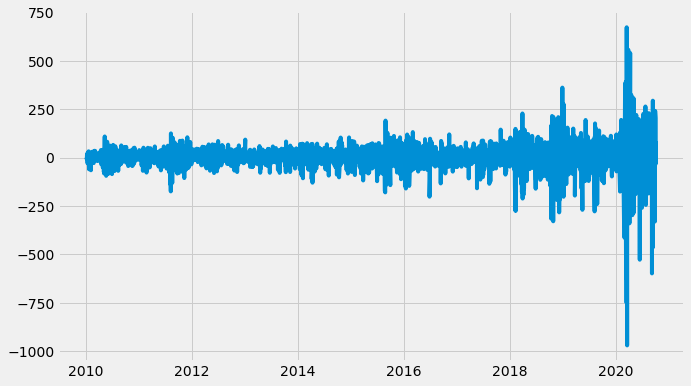

In [269]:
#To covert data into stationary dataset, first differencing has to be applied. With first differencing, empty field needs to be filled as 0. 
plt.plot(df['Close'].diff(1).fillna(0))


In [270]:
#confirm stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(df['Close']).diff(1).fillna(0))
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -11.770291597674845
p-value:1.0940406662618215e-21


In [271]:
df_st= df.diff(1).fillna(0)

In [272]:
#understand the structure of the stationary dataset
df_st.head()

,Close,year,month,day
Date,,,,
2010-01-04,0.000000,0.0,0.0,0.0
2010-01-05,0.290039,0.0,0.0,1.0
2010-01-06,-7.619873,0.0,0.0,1.0
2010-01-07,-1.040039,0.0,0.0,1.0
2010-01-08,17.119873,0.0,0.0,1.0


In [275]:
#With transformation to maintain stationarity, we need to be model back to the original dataset in order to predict stock price. 
df_revert=df_st.copy()
df_revert=df_revert.cumsum()

In [324]:
df_revert.iloc[0,:]=df.iloc[0,:]
df_revert = df_revert.cumsum()


In [325]:
#define data
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.revert = self.revert(self.stationary, self.data)
        
    def revert(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [283]:
#split dataset
x_train = TimeSeriesData(df[:int((len(df)*0.8))])
x_test = TimeSeriesData(df[int((len(df)*0.8)):])


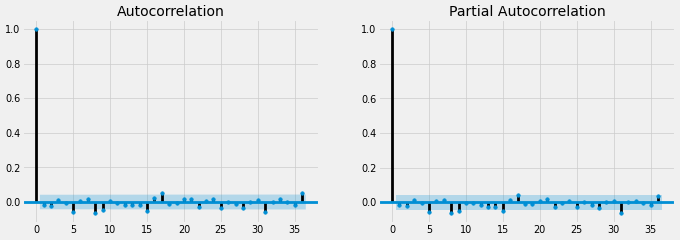

In [284]:
#plot ACF and PACF for the stationary dataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi= 50)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=36, ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=36, ax=axes[1]);

In [285]:
#using auto_arima to aquire p and q value with min AIC. 
from pmdarima import auto_arima
model = auto_arima(x_train.data['Close'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(x_train.data['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22406.770, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22400.729, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22402.090, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22402.065, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22406.532, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22393.839, Time=1.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22404.619, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22404.702, Time=1.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22402.822, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22402.801, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22406.446, Time=0.31 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 7.278 seconds


ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [286]:
model_arima = ARIMA(x_train.data['Close'].values, order=(1,1,1))

In [287]:
result_arima = model_arima.fit(disp=-1)

In [288]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2163
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11192.925
Method:                       css-mle   S.D. of innovations             42.767
Date:                Tue, 17 Nov 2020   AIC                          22393.851
Time:                        01:05:02   BIC                          22416.568
Sample:                             1   HQIC                         22402.159
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5691      0.570      4.506      0.000       1.452       3.687
ar.L1.D.y      0.9330      0.027     34.756      0.000       0.880       0.986
ma.L1.D.y     -0.9587      0.021    -45.615      0.0

In [289]:
#understand residual 
residuals = pd.DataFrame(result_arima.resid)

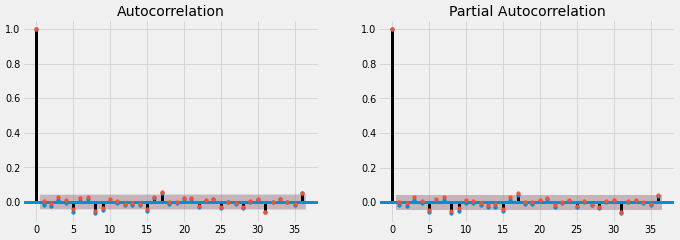

In [290]:
plot_acf(residuals, lags=36, ax=axes[0])
plot_pacf(residuals, lags=36, ax=axes[1])

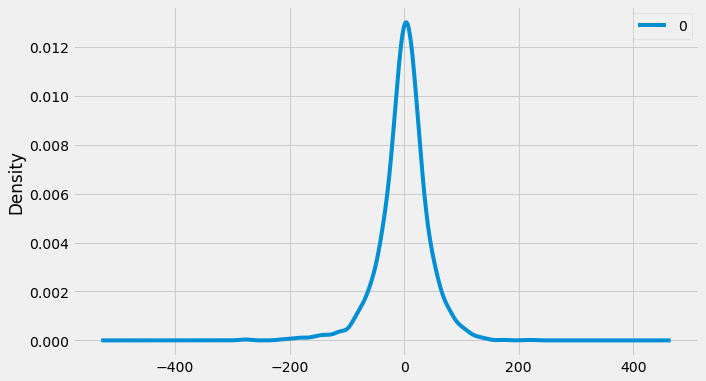

In [291]:
residuals.plot(kind='kde')

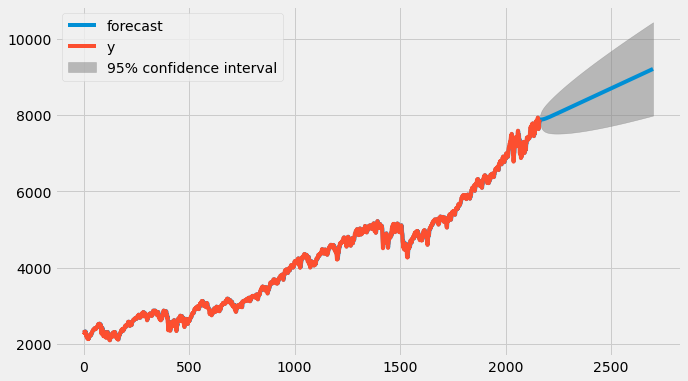

In [292]:
result_arima.plot_predict(1,2700);

In [301]:
prediction = result_arima.predict(len(df)-200,len(df)-1)


In [302]:
from statsmodels.tools.eval_measures import rmse 
#RMSE for ARIMA Model
err_ARIMA = rmse(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
print('RMSE with ARIMA', err_ARIMA)

RMSE with ARIMA 889.678717079625


In [ ]:
#same analysis for TSX price

In [305]:
#upload TSX price
df=pd.read_csv("GSPTSE_v1.csv", sep=",")

In [309]:
#understand the data and covert date format
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', length=2697, freq=None)

In [310]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [311]:
df.head()

,Close,year,month,day
Date,,,,
2010-01-04,11866.90039,2010,1,4
2010-01-05,11888.09961,2010,1,5
2010-01-06,11944.50000,2010,1,6
2010-01-07,11887.50000,2010,1,7
2010-01-08,11953.79981,2010,1,8


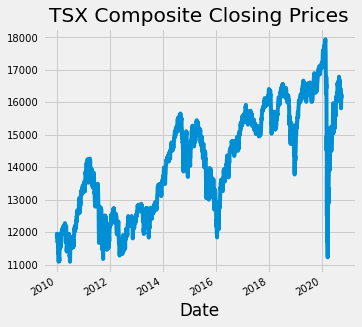

In [312]:
#plot TSX trend
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(5,5), title= 'TSX Composite Closing Prices', fontsize=10)

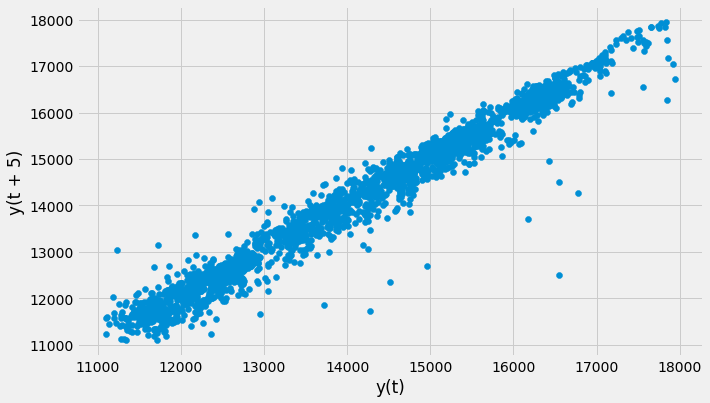

In [307]:
#lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'],lag=5)
#a linear plot also indicates non random dataset

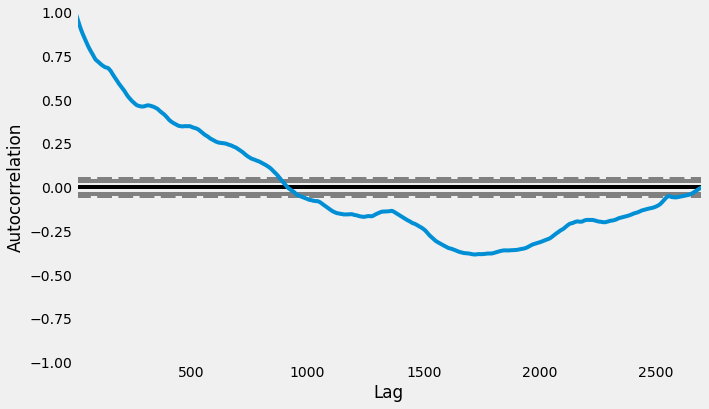

In [313]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
#autocorrelation suggests arima might be a good model

In [314]:
#original data shows as not stationary due to high p level
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -2.1272017170757755
p-value:0.23371823999228158


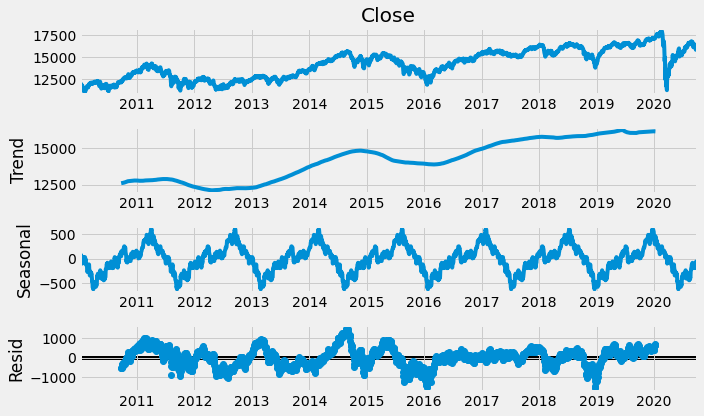

In [315]:
#decompose data
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df['Close'],model= 'addictive',period = 365)
resplot = res.plot()
#upward trend

In [317]:
def plot_df(df,x,y,title= "", xlabel = "Date", ylabel='Value',dpi=50):
    plt.plot(x,y)
    plt.show()

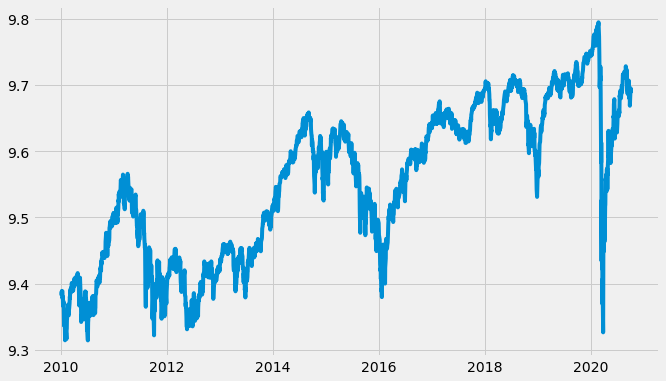

In [318]:
#apply log transformation to stablize data
plt.plot(df.apply(np.log)['Close'])

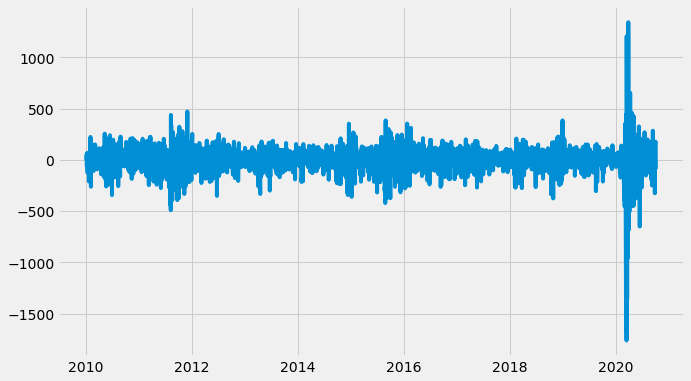

In [319]:
#To covert data into stationary dataset, first differencing has to be applied. With first differencing, empty field needs to be filled as 0. 
plt.plot(df['Close'].diff(1).fillna(0))


In [320]:
#confirm stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(df['Close']).diff(1).fillna(0))
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -10.92108896454532
p-value:1.037610106877016e-19


In [321]:
df_st= df.diff(1).fillna(0)

In [322]:
#understand the structure of the stationary dataset
df_st.head()

,Close,year,month,day
Date,,,,
2010-01-04,0.00000,0.0,0.0,0.0
2010-01-05,21.19922,0.0,0.0,1.0
2010-01-06,56.40039,0.0,0.0,1.0
2010-01-07,-57.00000,0.0,0.0,1.0
2010-01-08,66.29981,0.0,0.0,1.0


In [323]:
#With transformation to maintain stationarity, we need to be model back to the original dataset in order to predict stock price. 
df_revert=df_st.copy()
df_revert=df_revert.cumsum()

In [331]:
df_revert.iloc[0,:]=df.iloc[0,:]
df_revert = df_revert.cumsum()

In [332]:
#define data
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.revert = self.revert(self.stationary, self.data)
        
    def revert(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [352]:
#split dataset
x_train = TimeSeriesData(df[:int((len(df)*0.85))])
x_test = TimeSeriesData(df[int((len(df)*0.85)):])

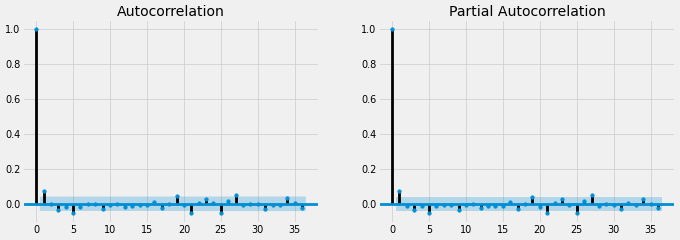

In [353]:
#plot ACF and PACF for the stationary dataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi= 50)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=36,ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=36,ax=axes[1]);

In [354]:
#using auto_arima to aquire p and q value with min AIC. 
from pmdarima import auto_arima
model = auto_arima(x_train.data['Close'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(x_train.data['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27707.940, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27722.152, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27711.070, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27711.001, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27720.872, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27714.994, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27707.115, Time=1.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27712.993, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27712.917, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27707.866, Time=1.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27712.282, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27708.220, Time=2.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=27706.090, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27711.613, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [355]:
model_arima = ARIMA(x_train.data['Close'].values, order=(2,1,1))

In [356]:
result_arima = model_arima.fit(disp=-1)

In [357]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2291
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -13848.621
Method:                       css-mle   S.D. of innovations            102.089
Date:                Tue, 17 Nov 2020   AIC                          27707.242
Time:                        01:20:14   BIC                          27735.926
Sample:                             1   HQIC                         27717.702
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7918      1.819      0.985      0.325      -1.773       5.357
ar.L1.D.y      0.9619      0.058     16.567      0.000       0.848       1.076
ar.L2.D.y     -0.0939      0.021     -4.491      0.0

In [358]:
#understand residual 
residuals = pd.DataFrame(result_arima.resid)

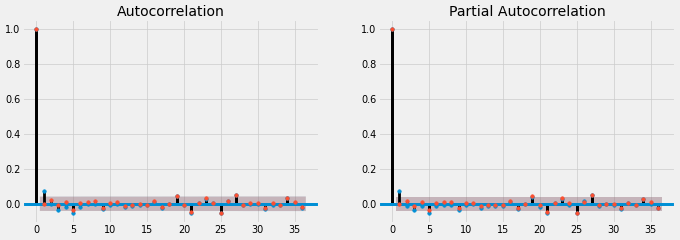

In [359]:
plot_acf(residuals, lags=36, ax=axes[0])
plot_pacf(residuals, lags=36, ax=axes[1])

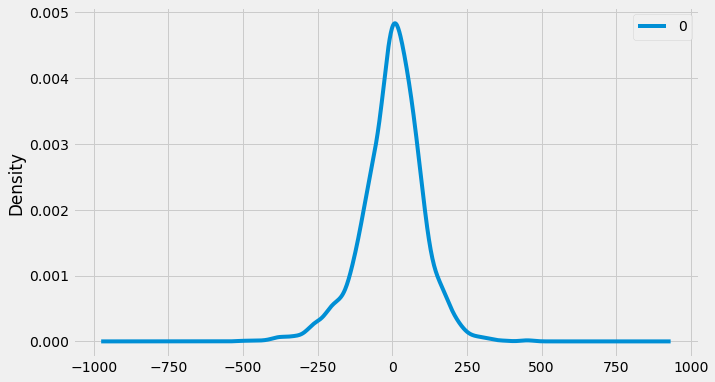

In [360]:
residuals.plot(kind='kde')

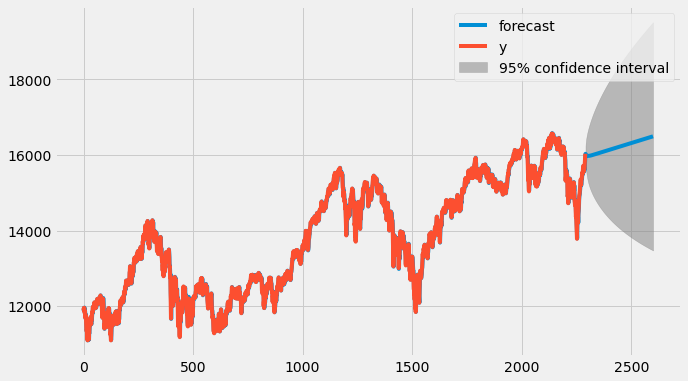

In [364]:
result_arima.plot_predict(1,2600);

In [365]:

prediction = result_arima.predict(len(df)-208,len(df)-1)


In [366]:
from statsmodels.tools.eval_measures import rmse 
#RMSE for ARIMA Model
err_ARIMA = rmse(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
print('RMSE with ARIMA', err_ARIMA)

RMSE with ARIMA 1145.9902860642562


In [ ]:
#using LSTM to predict stock price

In [44]:
pip install tensorflow

  Using cached tensorflow-2.3.1-cp37-cp37m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached grpcio-1.33.2-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.4.0-py3-none-any.whl (10.6 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-0.11.0-py3-none-any.whl (127 kB)
Processing ./.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2/termcolor-1.1.0-py3-none-any.whl
Processing ./.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6/wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
  Using cached Markdown-3.3.3-py3-none-a

In [45]:
pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [380]:
from pandas_datareader import data
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [449]:
#similar to before, upload NASDAQ data
df=pd.read_csv("IXIC_v1.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[2164:]
train = df[:2163]

In [450]:
df['Date'] = df.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = df['Date']
data2['Close'] = df['Close']

In [451]:
#scale and reshape data
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 2600):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [452]:
#add layers
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [453]:
#add optimizer and build model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 30, batch_size = 30)


Epoch 1/30
85/85 [==============================] - 13s 154ms/step - loss: 0.0071
Epoch 2/30
85/85 [==============================] - 12s 146ms/step - loss: 0.0018
Epoch 3/30
85/85 [==============================] - 12s 143ms/step - loss: 0.0016
Epoch 4/30
85/85 [==============================] - 12s 143ms/step - loss: 0.0014
Epoch 5/30
85/85 [==============================] - 12s 141ms/step - loss: 0.0013
Epoch 6/30
85/85 [==============================] - 12s 140ms/step - loss: 0.0013
Epoch 7/30
85/85 [==============================] - 12s 138ms/step - loss: 0.0012
Epoch 8/30
85/85 [==============================] - 11s 135ms/step - loss: 0.0012
Epoch 9/30
85/85 [==============================] - 13s 151ms/step - loss: 0.0011
Epoch 10/30
85/85 [==============================] - 12s 147ms/step - loss: 0.0010
Epoch 11/30
85/85 [==============================] - 12s 137ms/step - loss: 0.0010
Epoch 12/30
85/85 [==============================] - 12s 136ms/step - loss: 9.9016e-04
Epoch 13/

In [454]:
#train the model
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 601):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [455]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


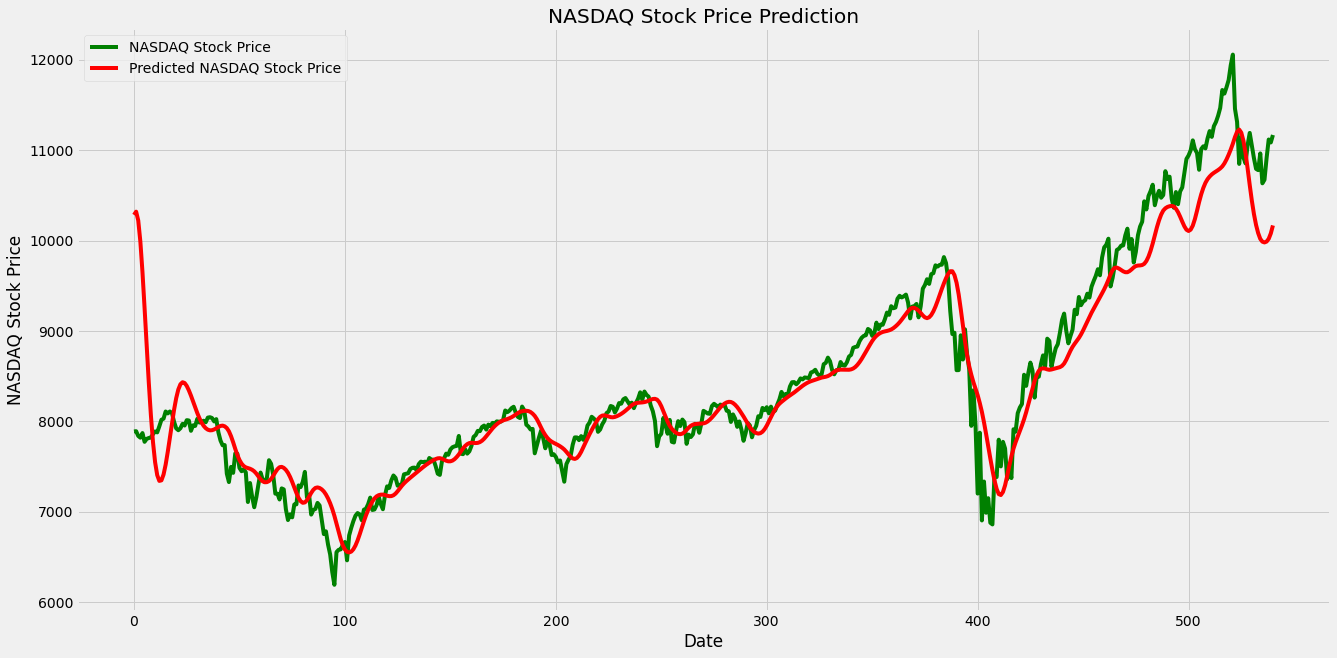

In [456]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'NASDAQ Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted NASDAQ Stock Price')
plt.title('NASDAQ Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Stock Price')
plt.legend()
plt.show()

In [457]:
rmse_predict= np.reshape(predicted_stock_price,541)

In [458]:
test["Close"].values.shape

(541,)

In [459]:
rmse_predict.shape

(541,)

In [460]:
#RMSE for LSTM Model
err_LSTM = rmse(test["Close"].values, rmse_predict)
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 391.79083600796884


In [405]:
#repeat the same process for TSX
df=pd.read_csv("GSPTSE_v1.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[2164:]
train = df[:2163]

In [406]:
df['Date'] = df.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = df['Date']
data2['Close'] = df['Close']

In [407]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 2600):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [408]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [417]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 80, batch_size = 32)

Epoch 1/80
80/80 [==============================] - 13s 162ms/step - loss: 0.0013
Epoch 2/80
80/80 [==============================] - 13s 163ms/step - loss: 0.0013
Epoch 3/80
80/80 [==============================] - 12s 151ms/step - loss: 0.0013
Epoch 4/80
80/80 [==============================] - 13s 158ms/step - loss: 0.0011
Epoch 5/80
80/80 [==============================] - 13s 160ms/step - loss: 0.0013
Epoch 6/80
80/80 [==============================] - 12s 155ms/step - loss: 0.0011
Epoch 7/80
80/80 [==============================] - 14s 178ms/step - loss: 0.0011
Epoch 8/80
80/80 [==============================] - 12s 154ms/step - loss: 0.0012
Epoch 9/80
80/80 [==============================] - 13s 156ms/step - loss: 0.0011
Epoch 10/80
80/80 [==============================] - 13s 162ms/step - loss: 0.0011
Epoch 11/80
80/80 [==============================] - 11s 143ms/step - loss: 0.0012
Epoch 12/80
80/80 [==============================] - 11s 139ms/step - loss: 0.0011
Epoch 13/80
8

In [418]:
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 593):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [419]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

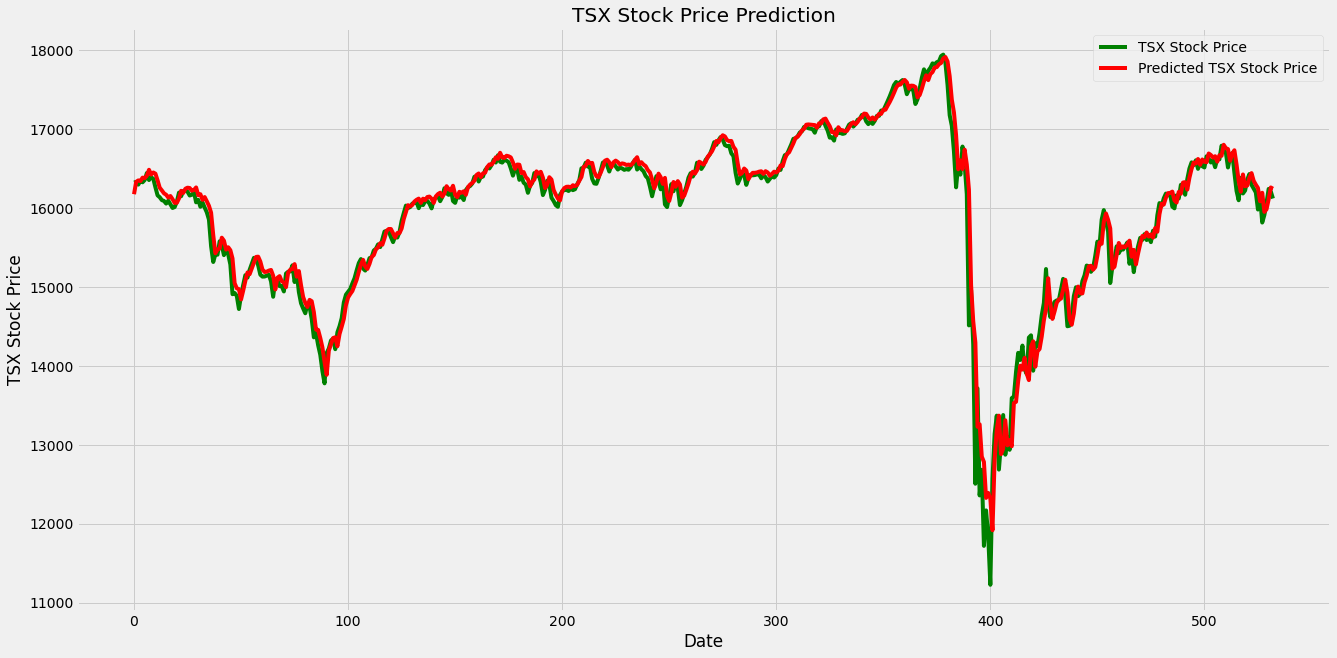

In [420]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'TSX Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted TSX Stock Price')
plt.title('TSX Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TSX Stock Price')
plt.legend()
plt.show()

In [421]:
rmse_predict= np.reshape(predicted_stock_price,533)

In [422]:
test["Close"].values.shape

(533,)

In [423]:
rmse_predict.shape

(533,)

In [424]:
#RMSE for LSTM Model
err_LSTM = rmse(test["Close"].values, rmse_predict)
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 199.6917074408309
